# LSTM Multivariate Model

In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from sklearn.impute import KNNImputer

In [2]:
X_train = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train_scaled.csv')
X_cv = pd.read_csv('X_val_scaled.csv')
y_cv = pd.read_csv('y_val_scaled.csv')
X_train_cv = pd.read_csv('X_train_val_scaled.csv')
y_train_cv = pd.read_csv('y_train_val_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')
y_test = pd.read_csv('y_test_scaled.csv')

val =  pd.read_csv('val.csv')
y_val = pd.read_csv('y_val.csv')
test =  pd.read_csv('test.csv')
test_y = pd.read_csv('y_test.csv')

 ## Defining LSTM Model & MAPE Functions

In [3]:
def run(neurons, batchSize, numEpochs, X, Y, pred_set, orig, col_mean, col_std):
    #Reshaping
    trainX =np.array(X)
    X = trainX.reshape(X.shape[0], 1, X.shape[1])
    
    testX =np.array(pred_set)
    pred_set = testX.reshape(pred_set.shape[0], 1, pred_set.shape[1])
    
    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(neurons, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss="mean_squared_error", optimizer="adam")
    plot_model(lstm, show_shapes=True, show_layer_names=True)

    ##################################################
    
    # Fitting the RNN to the Training set
    history = lstm.fit(X, Y, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False)
    predicted_Price = lstm.predict(pred_set)
    
    predicted_price_df = pd.DataFrame(predicted_Price, columns=['Predicted Price'])
    
    # Scale Back Result
    est = predicted_price_df['Predicted Price'] * col_std + col_mean

    rmse = sqrt(mean_squared_error(orig, est))
    mape = get_mape(orig, est)
    
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [4]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Param

In [5]:
# vary training batches
param_label = 'epochs'
param_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# param_list = [10]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32
default_neurons = 32

for param in param_list:
    rmse, mape = run(default_neurons, default_batch_size, param, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2022-04-29 07:58:33.488023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
14/14 [==============================] - 1s 1ms/step - loss: 0.0728
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0349
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 11/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 12/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 13/50
14/14 [==============================

,epochs,rmse,mape
0,50,2641.040173,18.144594
1,100,2630.973609,18.158818
2,150,2616.054878,18.148581
3,200,2627.947785,18.172055
4,250,2606.525576,18.168015
5,300,2645.067996,18.183668
6,350,2650.684825,18.179118
7,400,2651.413764,18.232872
8,450,2655.957851,18.223902
9,500,2627.648600,18.223398


In [6]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 2606.526
optimum params = 250


In [7]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 18.145%
optimum params = 50


## Tuning Batch Size Parameter

In [8]:
# vary training batches
param_label = 'batch_size'
param_list = [32, 64, 128, 256]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_neurons = 32

for param in param_list:
    rmse, mape = run(default_neurons, param, epoch_opt, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/250
14/14 [==============================] - 1s 1ms/step - loss: 0.1055
Epoch 2/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0441
Epoch 3/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 4/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 5/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 6/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 7/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 9/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 10/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 11/250
14/14 [=================

,batch_size,rmse,mape
0,32,2609.288025,18.168763
1,64,2638.233237,18.198001
2,128,2631.190451,18.193973
3,256,2620.212417,18.153478


In [9]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 2609.288
optimum params = 32


In [10]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 18.153%
optimum params = 256


In [11]:
# vary neurons
param_label = 'neurons'
param_list = [10, 20, 30, 40, 50]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32

for param in param_list:
    rmse, mape = run(param, default_batch_size, epoch_opt, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/250
14/14 [==============================] - 1s 1ms/step - loss: 0.3044
Epoch 2/250
14/14 [==============================] - 0s 2ms/step - loss: 0.2275
Epoch 3/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1963
Epoch 4/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1806
Epoch 5/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1717
Epoch 6/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1655
Epoch 7/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1604
Epoch 8/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1560
Epoch 9/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1519
Epoch 10/250
14/14 [==============================] - 0s 2ms/step - loss: 0.1481
Epoch 11/250
14/14 [=================

,neurons,rmse,mape
0,10,2729.021577,18.319674
1,20,2655.643062,18.197277
2,30,2591.546223,18.152344
3,40,2643.792114,18.199573
4,50,2623.486293,18.168075


In [12]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
neurons_opt = temp['neurons'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(neurons_opt))

min RMSE = 2591.546
optimum params = 30


In [13]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['neurons'].values[0]))

min MAPE = 18.152%
optimum params = 30


## Model with Optimal Parameters

In [14]:
# Process the data for LSTM
testX =np.array(X_test)
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
traincvX =np.array(X_train_cv)
X_train_cv = traincvX.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])

In [15]:
# Building the LSTM Model

start = time.time()


lstm = Sequential()
lstm.add(LSTM(neurons_opt, input_shape=(1, traincvX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

# Model Training
history = lstm.fit(X_train_cv, y_train_cv, epochs = epoch_opt, batch_size = batch_size_opt, verbose=1, shuffle=False)
# LSTM Prediction
y_pred = lstm.predict(X_test)

predicted_price_df = pd.DataFrame(y_pred, columns=['Predicted Price'])
    
# Scale Back Result
est = predicted_price_df['Predicted Price'] * test['Close_std'] + test['Close_mean']

end = time.time()
time_elapsed = end - start
print("Time Elapsed = ", time_elapsed)


rmse = sqrt(mean_squared_error(test_y, est))
mape = get_mape(test_y, est)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/250
19/19 [==============================] - 1s 2ms/step - loss: 0.0656
Epoch 2/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0486
Epoch 3/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 4/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 5/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 6/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 7/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 8/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 9/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 10/250
19/19 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 11/250
19/19 [=================

# AutoCorrelation Analysis

In [16]:
est5 = est
est4 = est
est3 = est
est2 = est
est1 = est
est5

0      55129.207499
1      55058.096973
2      56203.068677
3      56542.598807
4      57235.313809
           ...     
140    38900.370685
141    38803.958792
142    40842.672096
143    42638.002208
144    43701.726640
Length: 145, dtype: float64

In [17]:
test5_y = test_y
test4_y = test_y
test3_y = test_y
test2_y = test_y
test1_y = test_y
test1_y

,Close
0,54663.6
1,57471.9
2,56004.5
3,57367.2
4,57344.9
...,...
140,37706.7
141,43179.8
142,44428.2
143,43896.9


In [18]:
delay_df_5 = test5_y.merge(est5.to_frame(), left_index=True, right_index=True)
delay_df_5 = delay_df_5.reset_index()
delay_df_5 = delay_df_5.drop(columns=['index'])
delay_df_5 = delay_df_5.to_numpy()
delay_df_5 = delay_df_5.flatten()
indexer_5 = np.arange(10)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_4 = test4_y.merge(est4.to_frame(), left_index=True, right_index=True)
delay_df_4 = delay_df_4.reset_index()
delay_df_4 = delay_df_4.drop(columns=['index'])
delay_df_4 = delay_df_4.to_numpy()
delay_df_4 = delay_df_4.flatten()
indexer_4 = np.arange(8)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_3 = test3_y.merge(est3.to_frame(), left_index=True, right_index=True)
delay_df_3 = delay_df_3.reset_index()
delay_df_3 = delay_df_3.drop(columns=['index'])
delay_df_3 = delay_df_3.to_numpy()
delay_df_3 = delay_df_3.flatten()
indexer_3 = np.arange(6)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_2 = test2_y.merge(est2.to_frame(), left_index=True, right_index=True)
delay_df_2 = delay_df_2.reset_index()
delay_df_2 = delay_df_2.drop(columns=['index'])
delay_df_2 = delay_df_2.to_numpy()
delay_df_2 = delay_df_2.flatten()
indexer_2 = np.arange(4)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_1 = test1_y.merge(est1.to_frame(), left_index=True, right_index=True)
delay_df_1 = delay_df_1.reset_index()
delay_df_1 = delay_df_1.drop(columns=['index'])
delay_df_1 = delay_df_1.to_numpy()
delay_df_1 = delay_df_1.flatten()
indexer_1 = np.arange(2)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

In [19]:
# window size 5
rmse_mean = 0
mape_mean = 0
for i in range(140-5+1):
    window = delay_df_5[indexer_5][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-5+1)  
mape_mean = mape_mean/(140-5+1) 

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 2507.874
MAPE on test set = 4.213%


In [20]:
# window size 4
rmse_mean = 0
mape_mean = 0
for i in range(140-4+1):
    window = delay_df_4[indexer_4][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-4+1)
mape_mean = mape_mean/(140-4+1) 

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 2451.828
MAPE on test set = 4.201%


In [21]:
# window size 3
rmse_mean = 0
mape_mean = 0
for i in range(140-3+1):
    window = delay_df_3[indexer_3][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-3+1)
mape_mean = mape_mean/(140-3+1)

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 2376.756
MAPE on test set = 4.184%


In [22]:
# window size 2
rmse_mean = 0
mape_mean = 0
for i in range(140-2+1):
    window = delay_df_2[indexer_2][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-2+1)
mape_mean = mape_mean/(140-2+1)

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 2286.493
MAPE on test set = 4.173%


In [23]:
# window size 1
rmse_mean = 0
mape_mean = 0
for i in range(140-1+1):
    window = delay_df_1[indexer_1][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-1+1)  
mape_mean = mape_mean/(140-1+1) 

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 2133.780
MAPE on test set = 4.152%


Consistent MAPE with fairly consistent fall in RMSE across the window sizes, suggesting some form of consistency in the improvement of the results. Choose the window size with the lowest RMSE and adjust for delay

In [24]:
est = est[1:]
test_y = test_y[:-1]

est = est.reset_index(drop = True)
test_y = test_y.to_numpy()
test_y = test_y.flatten()
test_y = pd.Series(test_y) 

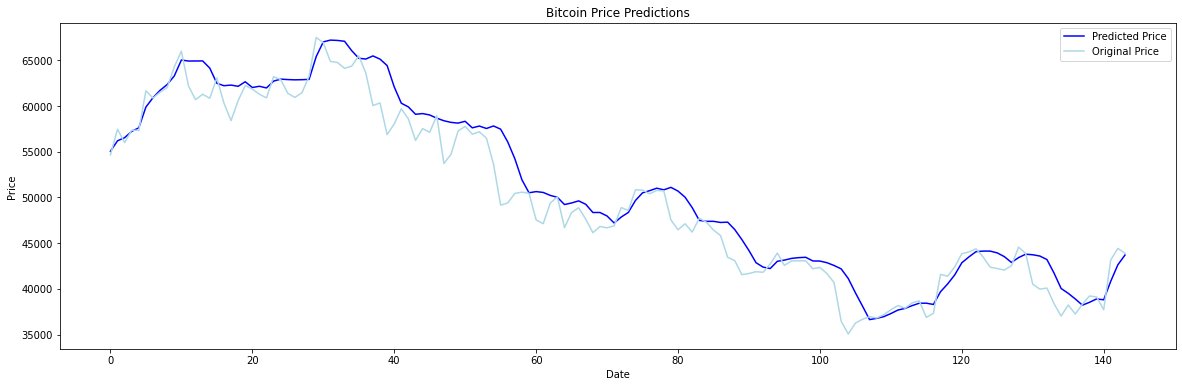

In [25]:
plt.plot(est, color = 'blue', label = 'Predicted Price')
plt.plot(test_y, color = 'lightblue', label = 'Original Price')
 
plt.title('Bitcoin Price Predictions')
plt.xlabel('Date')
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Prediction

In [26]:
predict_feature = pd.read_csv('predict_feature.csv')

In [27]:
# Process the data for LSTM
testX =np.array(predict_feature)
predict_feature = testX.reshape(predict_feature.shape[0], 1, predict_feature.shape[1])
predict_feature

array([[[0.53494289, 0.62718398, 0.63747015, 0.30237581, 0.19623401,
         0.25062473, 0.46436467, 0.46944603, 0.28855979, 0.54238339,
         0.61126824, 0.65190672, 0.30237581, 0.20485842, 0.23595433,
         0.42488987, 0.45316945, 0.26122203, 0.53940674, 0.59048656,
         0.7266844 , 0.28077754, 0.23291649, 0.22320121, 0.39781412,
         0.43610698, 0.23564326, 0.52835439, 0.5703024 , 0.65288979,
         0.30237581, 0.2276556 , 0.21294701, 0.36698343, 0.40669111,
         0.21667954, 0.53695683, 0.57208171, 0.63260644, 0.2699784 ,
         0.2392123 , 0.2168031 , 0.39695217, 0.43021982, 0.26408256]]])

In [28]:
predicted_price = lstm.predict(predict_feature)

predicted_price_df = pd.DataFrame(predicted_price, columns=['Predicted Price'])
    
# Scale Back Result
close_mean = test['Close_mean'][-5:].mean()
close_std = test['Close_std'][-5:].mean()
est = predicted_price_df['Predicted Price'] * close_std + close_mean

In [29]:
est

0    40942.410156
Name: Predicted Price, dtype: float32

Reality: Bitcoin currency had a close price of USD 39,137.61 on 4 Mar 2022.

Predicted: Our model predicted the currency to have a close price of USD 40942.410156 on 4 Mar 2022.